In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.audio import *

In [3]:
sg_cfg= SpectrogramConfig(hop=480, n_mels=128, n_fft=960, top_db=80, f_min=20.0, f_max=22050)
config_split= AudioConfig(resample_to = 8000, remove_silence = "all", silence_padding=200, silence_threshold=20, sg_cfg=sg_cfg, duration=10000)

In [4]:
train_df = pd.read_csv(Path("./data/train.tsv"),sep="\t")

In [5]:
class DeepSpeechAudioList(AudioList):
    _bunch = DataBunch
    def __init__(self, items, path, config=AudioConfig(), context=5, **kwargs):
        super().__init__(items=items, path=path, config=config, **kwargs)
        self.context = context
        
    def get(self,i):
        one_spectro = super().get(i).spectro
        one_spectro = F.pad(one_spectro, pad=(self.context,self.context))
        return torch.stack([one_spectro[:,:,i:i+(self.context*2+1)].squeeze() for i in range(one_spectro.shape[-1]-(self.context*2))])

In [6]:
class SentenceCharList(ItemList):
    itoc = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"," ","'",""]
    ctoi = defaultdict(lambda: 28)
    def __init__(self, items, path, **kwargs):
        super().__init__(items, **kwargs)
        for i,char in enumerate(self.itoc):
            self.ctoi[char]=i
        
    def get(self,i):
#        return torch.tensor([self.ctoi[j] for j in self.items[i].lower()])
        return F.pad(torch.tensor([self.ctoi[j] for j in self.items[i].lower()]), pad=(0,200), mode='constant', value=28)[:100]

In [7]:
#My solution to having to look through training files to make sure they are in training and not validation. 
train_file = defaultdict(bool)
for i in train_df.path:
    train_file[i] = True

In [8]:
data = (DeepSpeechAudioList.from_folder("data/clips", config=config_split)#, processor=[rs])
        .use_partial_data(0.005, seed=42)
        .filter_by_func(lambda x: train_file[x.name])
        .split_by_rand_pct(0.2, seed=42)
        .label_from_func(lambda x: train_df[train_df.path==str(x).split("/")[-1]]["sentence"].iloc[0], label_cls=SentenceCharList)
        .databunch(bs=5)
       )

Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


In [9]:
data.train_ds.x[0].shape

torch.Size([166, 128, 11])

In [10]:
class DeepSpeech(nn.Module):
    def __init__(self, context=5, bs=64):
        super(DeepSpeech, self).__init__()
        self.bs = bs
        self.context = context
        self.h = None#(torch.zeros((2,5,2048)).cuda(),torch.zeros((2,5,2048)).cuda())#None
        self.flatten = nn.Flatten()#lambda x: torch.reshape(x,(-1,1,2432))
        self.h1 = nn.Linear(128*2*self.context+128,2048)
        self.h2 = nn.Linear(2048,2048)
        self.h3 = nn.Linear(2048,2048)
        self.h4 = nn.LSTM(2048,2048,batch_first=True)#bidirectional=True,batch_first=True)
        #self.h4 = nn.RNN(2048,2048, nonlinearity="relu",bidirectional=True)
        self.h5 = nn.Linear(2048,29) #ct ∈ {a,b,c, . . . , z, space, apostrophe, blank}
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = nn.Flatten(-2,-1)(x)#torch.stack(x,dim=1)
        x = self.h1(x).clamp(min=0, max=20)
        x = self.h2(x).clamp(min=0, max=20)
        x = self.h3(x).clamp(min=0, max=20)
        if self.h is None:
            ;
        elif self.h[0].shape[1]>x.size(0):
            self.h=tuple([each[:,:x.size(0),:] for each in model.h])
        elif self.h[0].shape[1]<x.size(0):
            self.h=None#tuple([each.expand(-1,x.size(0),-1) for each in model.h])
        x,h = self.h4(x, self.h)
        self.h = to_detach(h, cpu=False)
        x = x.view(-1,166,1,2048)
        x = x.sum(dim=2)
        x = self.h5(x).clamp(min=0, max=20)
        x = self.softmax(x)
        return x

In [11]:
def ctc_loss(input, target, bs=64):
    r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
    input = input.permute(1,0,2).detach().requires_grad_()
    ctc = nn.CTCLoss(blank=28, zero_infinity=True, reduction="sum")
    ret = ctc(input, target, input_lengths=torch.tensor([166]*input.size(1)), target_lengths=torch.tensor([100]*input.size(1)))
    return ret

In [12]:
model = DeepSpeech(context=5, bs=5)

In [13]:
learn = Learner(data, model, loss_func=partial(ctc_loss,bs=5), opt_func=AdamW)

In [14]:
#ctc_loss(inp,data.one_batch()[1].cuda(), bs=2)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [78]:
# epochs=1
# callbacks = [cb(learn) for cb in learn.callback_fns + listify(defaults.extra_callback_fns)]
# cb_handler = CallbackHandler(callbacks, None)
# pbar = master_bar(range(epochs))
# cb_handler.on_train_begin(epochs, pbar=pbar, metrics=None)
# learn.model.train()
# cb_handler.set_dl(learn.data.train_dl)
# cb_handler.on_epoch_begin()
# xb,yb = next(iter(data.train_dl))
# xb,yb = cb_handler.on_batch_begin(xb,yb)
# learn.loss_func
# learn.opt
# loss_batch??
# loss_batch(learn.model, xb,yb, learn.loss_func, learn.opt, cb_handler)
# xb=[xb]
# yb=[yb]
# out = learn.model(*xb)
# out = cb_handler.on_loss_begin(out)
# loss = learn.loss_func(out, *yb)
# loss
# learn.loss_func

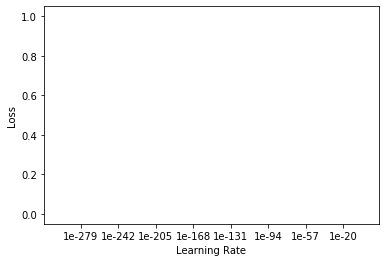

In [16]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10,1e-5)

epoch,train_loss,valid_loss,time
0,-336.870270,-347.053528,00:03
1,-342.174011,-347.058960,00:03
2,-335.073914,-347.060364,00:03
3,-340.327209,-347.063568,00:03
4,-339.494385,-347.061188,00:03
5,-342.326019,-347.059998,00:03
6,-343.867188,-347.059174,00:03
7,-344.880493,-347.056793,00:03


In [20]:
preds,targs = learn.get_preds()

In [21]:
preds.shape

torch.Size([61, 166, 29])

In [22]:
targs.shape

torch.Size([61, 100])

In [23]:
preds.argmax(dim=2)[0]

tensor([ 7,  7, 25, 25, 25, 25, 25, 25, 25, 16,  5, 15, 15, 15, 15, 15, 24, 24,
        24, 24, 21, 21, 13, 13, 13, 13, 13, 15, 22, 22, 22, 22, 21, 21, 21, 22,
        22, 22, 22, 24, 22, 24, 24, 24, 24, 21, 22, 24, 22, 22, 24, 24, 14, 14,
        14, 14, 21, 24, 24, 11, 14, 14, 14, 14, 14, 14, 14, 21, 21, 21, 21, 21,
        21, 27, 27, 27, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25])

In [24]:
targs[0]

tensor([12, 24, 26,  9,  4, 22,  4, 11, 18, 26,  0, 17,  4, 26,  0, 11, 11, 26,
         8, 13, 26, 19,  7,  4,  8, 17, 26, 15, 17, 14, 15,  4, 17, 26, 15, 11,
         0,  2,  4, 18, 26, 14,  5, 26, 10,  4,  4, 15,  8, 13,  6, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28])